<a href="https://colab.research.google.com/github/TimTree/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [1]:
### YOUR CODE STARTS HERE
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-09-16 19:40:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-09-16 19:40:49 (287 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [6]:
import pandas as pd
import numpy as np
# Load Data
df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [4]:
df.head()

,republican,n,y,n.1,y.1,y.2,y.3,n.2,n.3,n.4,y.4,?,y.5,y.6,y.7,n.5,y.8
0,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
1,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
2,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
3,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
4,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y


In [7]:
df.describe()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


In [8]:
df = df.replace({'?': np.NaN, 'n': 0, 'y': 1})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df['party'] == 'democrat']
rep = df[df['party'] == 'republican']

In [10]:
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [11]:
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [0]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

In [16]:
dem['handicapped-infants'].mean()

0.6046511627906976

In [15]:
rep['handicapped-infants'].mean()

0.18787878787878787

Null hypothesis:
Democrats and republicans support the handicapped infants issue the same.

Alternative hypothesis:
Democrats and republicans support the handicapped infants issue differently.

In [17]:
ttest_ind(dem['handicapped-infants'],rep['handicapped-infants'], nan_policy='omit')

Ttest_indResult(statistic=9.205264294809222, pvalue=1.613440327937243e-18)

T statistic: 9.205
P-Value 0.000000000000001613

Since the p-value is below the threshold of 0.05, we can reject the null hypothesis that democrats and republicans support the handicapped infants issue the same, favoring democrats.

In [18]:
dem['synfuels'].mean()

0.5058823529411764

In [19]:
rep['synfuels'].mean()

0.1320754716981132

In [20]:
ttest_ind(dem['synfuels'],rep['synfuels'],nan_policy='omit')

Ttest_indResult(statistic=8.293603989407588, pvalue=1.5759322301054064e-15)

T-statistic: 8.293
P-value: 0.000000000000157

Since the p-value is below the threshold of 0.05, we can reject the null hypothesis that democrats and republicans support the synfuels issue the same, favoring democrats.

In [21]:
dem['immigration'].mean()

0.4714828897338403

In [22]:
rep['immigration'].mean()

0.5575757575757576

In [25]:
ttest_ind(dem['immigration'],rep['immigration'],nan_policy='omit')

Ttest_indResult(statistic=-1.7359117329695164, pvalue=0.08330248490425066)

T-statistic: -1.736
P-value: 0.0833

Since the p-value is above the null hypothesis, we cannot reject the null hypothesis that democrats and republicans support the immigration issue the same.

In [26]:
dem['right-to-sue'].mean()

0.2896825396825397

In [27]:
rep['right-to-sue'].mean()

0.8607594936708861

In [28]:
ttest_ind(dem['right-to-sue'],rep['right-to-sue'],nan_policy='omit')

Ttest_indResult(statistic=-13.51064251060933, pvalue=1.2278581709672758e-34)

T-statistic: -13.510
P-value: Essentially 0

Since the p-value is less than the threshold of 0.05, we can reject the null hypothesis that democrats and republicans support the right-to-sue issue the same, favoring republicans.

In [0]:
def perform2SampleTTest(data1, data2):
  tstat = ttest_ind(data1, data2, nan_policy='omit').statistic
  pvalue = ttest_ind(data1, data2, nan_policy='omit').pvalue
  print('T-statistic: ' + str(tstat))
  print('P-value: ' + str(pvalue))
  if (pvalue >= 0.05):
    print('Since the p-value is equal or greater than 0.05, we cannot reject the null hypothesis.')
  else:
    print('Since the p-value is less than 0.05, we can reject the null hypothsis.')

In [33]:
perform2SampleTTest(dem['crime'],rep['crime'])

T-statistic: -16.342085656197696
P-value: 9.952342705606092e-47
Since the p-value is less than 0.05, we can reject the null hypothsis.


**Graphing with distplot**

In [34]:
dem.describe()

,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,258.000000,239.000000,260.000000,259.000000,255.000000,258.000000,259.000000,263.000000,248.000000,263.000000,255.000000,249.000000,252.000000,257.000000,251.000000,185.000000
mean,0.604651,0.502092,0.888462,0.054054,0.215686,0.476744,0.772201,0.828897,0.758065,0.471483,0.505882,0.144578,0.289683,0.350195,0.637450,0.935135
std,0.489876,0.501045,0.315405,0.226562,0.412106,0.500430,0.420224,0.377317,0.429121,0.500138,0.500949,0.352383,0.454518,0.477962,0.481697,0.246956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
rep.describe()

,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,165.000000,148.000000,164.000000,165.000000,165.000000,166.000000,162.000000,157.000000,165.000000,165.000000,159.000000,155.000000,158.000000,161.000000,156.000000,146.000000
mean,0.187879,0.506757,0.134146,0.987879,0.951515,0.897590,0.240741,0.152866,0.115152,0.557576,0.132075,0.870968,0.860759,0.981366,0.089744,0.657534
std,0.391804,0.501652,0.341853,0.109760,0.215442,0.304104,0.428859,0.361010,0.320176,0.498186,0.339643,0.336322,0.347298,0.135649,0.286735,0.476168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
xbar1 = dem['duty-free'].mean()
xbar2 = rep['duty-free'].mean()

s1 = dem['duty-free'].std()
s2 = rep['duty-free'].std()

n1 = dem['duty-free'].count()
n2 = rep['duty-free'].count()

In [0]:
dutyfree1 = np.random.normal(xbar1,s1,n1)

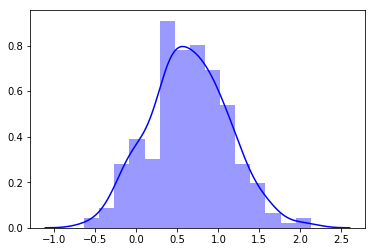

In [40]:
import seaborn as sns
ax = sns.distplot(dutyfree1, color='b')

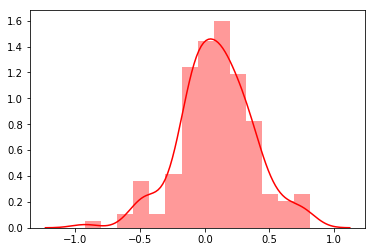

In [41]:
dutyfree2 = np.random.normal(xbar2,s2,n2)
ax = sns.distplot(dutyfree2, color='r')

**One sample t-test**

Null hypothesis: No republicans support the duty free policy (0.0%).
Alternate hypothsis: There's nonzero republican support for the duty free policy.

In [42]:
ttest_1samp(rep['duty-free'],0,nan_policy='omit')

Ttest_1sampResult(statistic=3.9091802389817065, pvalue=0.00013809783981978333)

Since the p-value is less than 0.05, we can reject the null hypothesis that no republicans support the duty-free policy.